In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Dataset path
indoor_dataset_dir = '/content/drive/MyDrive/Dataset/train'

Mounted at /content/drive


In [3]:
# Install packages needed
!pip install -U keras-cv split-folders
# Import the libraries needed for this dissertation
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
# TensorFlow / Keras for model building
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks, Input
from tensorflow.keras.models import Model
# InceptionV3 used as the CNN feature extraction branch
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
# Used for loading and augmenting the indoor scene image dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Training helpers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Vision Transformer (ViT) model from KerasCV (legacy namespace)
import keras_cv
from keras_cv.src.models.legacy import ViTTiny16
# Metrics for evaluation and confusion matrix generation
from sklearn.metrics import (confusion_matrix,ConfusionMatrixDisplay,classification_report)
# Utility for splitting dataset folders into train/val/test sets
import splitfolders
# Reduce TensorFlow log noise and ignore warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 60.5 MB/s eta 0:00:00


In [4]:
# Split the indoor scene dataset into training and validation subsets
splitfolders.ratio(indoor_dataset_dir,output="/content/IndoorScene_Split",seed=24000105,
    ratio=(0.70, 0.30),move=False)
# Directories for the resulting training and validation subsets
indoor_train_dir = "/content/IndoorScene_Split/train"
indoor_val_dir   = "/content/IndoorScene_Split/val"

Copying files: 3981 files [03:50, 17.29 files/s] 


In [5]:
# Image resolution used for all indoor scene classification models
indoor_image_size = (299, 299)
# Number of images processed per batch during training and validation
indoor_batch_size = 32
# Data augmentation applied to the indoor scene training images
indoor_train_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
# Generator for indoor scene validation images without augmentation
indoor_val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
# Loads the indoor scene training samples
indoor_train_loader = indoor_train_data_generator.flow_from_directory(
    indoor_train_dir,
    target_size=indoor_image_size,
    batch_size=indoor_batch_size,
    class_mode='categorical',
    shuffle=True)
# Loads the indoor scene validation samples
indoor_val_loader = indoor_val_data_generator.flow_from_directory(
    indoor_val_dir,
    target_size=indoor_image_size,
    batch_size=indoor_batch_size,
    class_mode='categorical',
    shuffle=False)
# Number of indoor scene categories
num_scene_classes = indoor_train_loader.num_classes
# Names of the indoor scene classes
scene_class_labels = list(indoor_train_loader.class_indices.keys())

Found 2777 images belonging to 15 classes.
Found 1204 images belonging to 15 classes.


In [6]:
# Load the InceptionV3 CNN backbone for indoor scene feature extraction
inception_cnn_backbone = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3))
# Freeze the convolutional backbone during initial training
inception_cnn_backbone.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
# Build the frozen InceptionV3 indoor scene classification model
cnn_features = inception_cnn_backbone.output
cnn_features = layers.GlobalAveragePooling2D()(cnn_features)
cnn_features = layers.Dense(512, activation='relu')(cnn_features)
cnn_features = layers.Dropout(0.5)(cnn_features)
scene_predictions = layers.Dense(num_scene_classes, activation='softmax')(cnn_features)
# Create the frozen Inception model
inception_model_frozen = models.Model(
    inputs=inception_cnn_backbone.input,
    outputs=scene_predictions)
# Compile the frozen Inception model
inception_model_frozen.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [8]:
# Early stopping to prevent overfitting during training
indoor_early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)
# Checkpoint to save the best-performing Inception model
inception_checkpoint = ModelCheckpoint(
    'best_inceptionv3_model.h5',
    monitor='val_accuracy',
    save_best_only=True)
# Train the frozen Inception model on indoor scene images
inception_frozen_history = inception_model_frozen.fit(
    indoor_train_loader,
    validation_data=indoor_val_loader,
    epochs=10,
    callbacks=[indoor_early_stop, inception_checkpoint])

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.3112 - loss: 2.2320

87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.3130 - loss: 2.2272 - val_accuracy: 0.7334 - val_loss: 1.0545
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.6666 - loss: 1.1883

87/87 ━━━━━━━━━━━━━━━━━━━━ 87s 998ms/step - accuracy: 0.6667 - loss: 1.1876 - val_accuracy: 0.7874 - val_loss: 0.7605
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.7347 - loss: 0.9017

87/87 ━━━━━━━━━━━━━━━━━━━━ 75s 863ms/step - accuracy: 0.7347 - loss: 0.9015 - val_accuracy: 0.8272 - val_loss: 0.6107
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.7582 - loss: 0.7789

87/87 ━━━━━━━━━━━━━━━━━━━━ 73s 840ms/step - accuracy: 0.7581 - loss: 0.7791 - val_accuracy: 0.8497 - val_loss: 0.5446
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 75s 858ms/step - accuracy: 0.7888 - loss: 0.6924 - val_accuracy: 0.8480 - val_loss: 0.5118
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.7750 - loss: 0.7156

87/87 ━━━━━━━━━━━━━━━━━━━━ 72s 827ms/step - accuracy: 0.7752 - loss: 0.7153 - val_accuracy: 0.8630 - val_loss: 0.4865
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 70s 808ms/step - accuracy: 0.7952 - loss: 0.6346 - val_accuracy: 0.8513 - val_loss: 0.4755
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.7978 - loss: 0.6322

87/87 ━━━━━━━━━━━━━━━━━━━━ 70s 802ms/step - accuracy: 0.7979 - loss: 0.6321 - val_accuracy: 0.8679 - val_loss: 0.4456
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.8262 - loss: 0.5568

87/87 ━━━━━━━━━━━━━━━━━━━━ 71s 813ms/step - accuracy: 0.8261 - loss: 0.5571 - val_accuracy: 0.8688 - val_loss: 0.4374
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 71s 814ms/step - accuracy: 0.8172 - loss: 0.5715 - val_accuracy: 0.8679 - val_loss: 0.4362


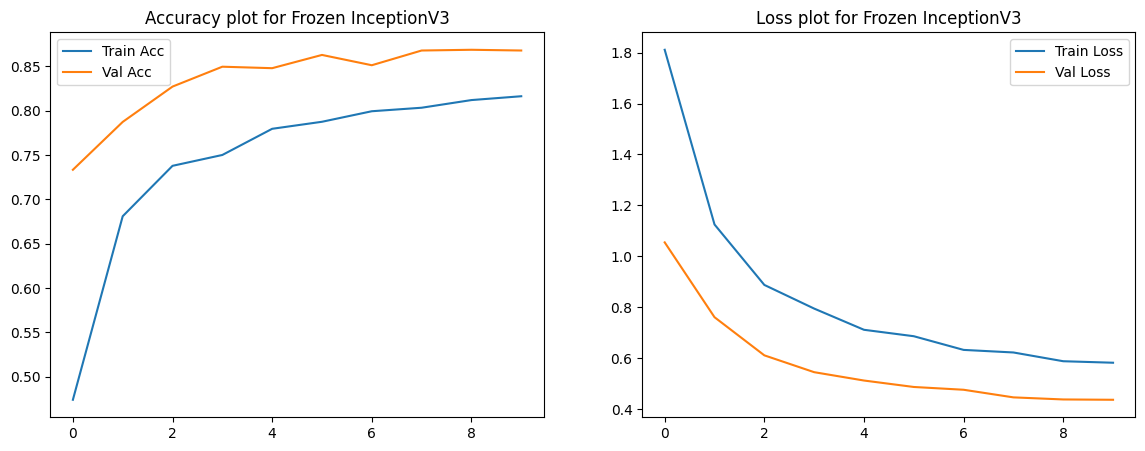

In [9]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(inception_frozen_history.history['accuracy'], label='Train Acc')
plt.plot(inception_frozen_history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy plot for Frozen InceptionV3")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(inception_frozen_history.history['loss'], label='Train Loss')
plt.plot(inception_frozen_history.history['val_loss'], label='Val Loss')
plt.title("Loss plot for Frozen InceptionV3")
plt.legend()
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 320ms/step


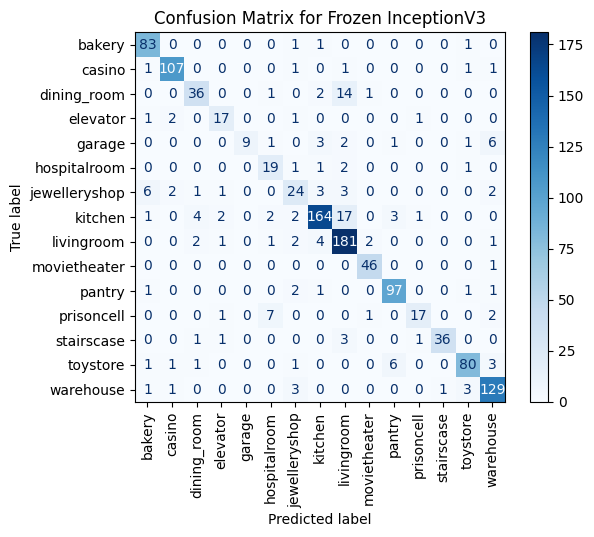

               precision    recall  f1-score   support

       bakery       0.87      0.97      0.92        86
       casino       0.95      0.96      0.95       112
  dining_room       0.80      0.67      0.73        54
     elevator       0.74      0.77      0.76        22
       garage       1.00      0.39      0.56        23
 hospitalroom       0.61      0.79      0.69        24
jewelleryshop       0.63      0.57      0.60        42
      kitchen       0.92      0.84      0.87       196
   livingroom       0.81      0.93      0.87       194
 movietheater       0.92      0.98      0.95        47
       pantry       0.91      0.94      0.92       103
   prisoncell       0.85      0.61      0.71        28
   stairscase       0.97      0.86      0.91        42
     toystore       0.91      0.86      0.88        93
    warehouse       0.88      0.93      0.91       138

     accuracy                           0.87      1204
    macro avg       0.85      0.80      0.82      1204
 weighte

In [10]:
# Generate predictions for the indoor scene validation set
indoor_val_loader.reset()
val_predictions_frozen = inception_model_frozen.predict(indoor_val_loader)
predicted_labels_frozen = np.argmax(val_predictions_frozen, axis=1)
true_labels = indoor_val_loader.classes
# Compute the confusion matrix for indoor scene classification
confusion_mat_frozen = confusion_matrix(true_labels, predicted_labels_frozen)
confusion_display = ConfusionMatrixDisplay(
    confusion_matrix=confusion_mat_frozen,
    display_labels=scene_class_labels)
confusion_display.plot(xticks_rotation='vertical',cmap='Blues')
plt.title("Confusion Matrix for Frozen InceptionV3")
plt.show()
# Classification report showing precision, recall, and F1-scores
print(classification_report(true_labels, predicted_labels_frozen, target_names=scene_class_labels))

In [11]:
# Unfreeze selected layers of the Inception backbone for fine-tuning
inception_cnn_backbone.trainable = True
# Freeze layers before the fine-tuning cutoff
fine_tune_layer_index = 250
for layer in inception_cnn_backbone.layers[:fine_tune_layer_index]:
    layer.trainable = False
# Rebuild the Inception model for fine-tuning
inception_model_finetuned = models.Model(
    inputs=inception_cnn_backbone.input,
    outputs=scene_predictions)
# Compile the fine-tuned Inception model
inception_model_finetuned.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
# Train the fine-tuned Inception model on indoor scene data
inception_finetuned_history = inception_model_finetuned.fit(
    indoor_train_loader,
    validation_data=indoor_val_loader,
    epochs=10,
    callbacks=[indoor_early_stop, inception_checkpoint])

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.7440 - loss: 0.8609 - val_accuracy: 0.8679 - val_loss: 0.3910
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.8651 - loss: 0.4397

87/87 ━━━━━━━━━━━━━━━━━━━━ 73s 838ms/step - accuracy: 0.8651 - loss: 0.4393 - val_accuracy: 0.8854 - val_loss: 0.3364
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.9063 - loss: 0.2978

87/87 ━━━━━━━━━━━━━━━━━━━━ 73s 832ms/step - accuracy: 0.9063 - loss: 0.2980 - val_accuracy: 0.8904 - val_loss: 0.3606
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.9177 - loss: 0.2464

87/87 ━━━━━━━━━━━━━━━━━━━━ 72s 833ms/step - accuracy: 0.9177 - loss: 0.2464 - val_accuracy: 0.9012 - val_loss: 0.3313
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 72s 825ms/step - accuracy: 0.9302 - loss: 0.2012 - val_accuracy: 0.8904 - val_loss: 0.3418
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 71s 820ms/step - accuracy: 0.9623 - loss: 0.1326 - val_accuracy: 0.8995 - val_loss: 0.3413
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 72s 823ms/step - accuracy: 0.9591 - loss: 0.1352 - val_accuracy: 0.8953 - val_loss: 0.3667


In [12]:
# Reference to the final fine-tuned Inception model
inception_final_model = inception_model_finetuned
# Save the final Inception model for indoor scene classification
inception_final_model.save("inception_final_model.h5")

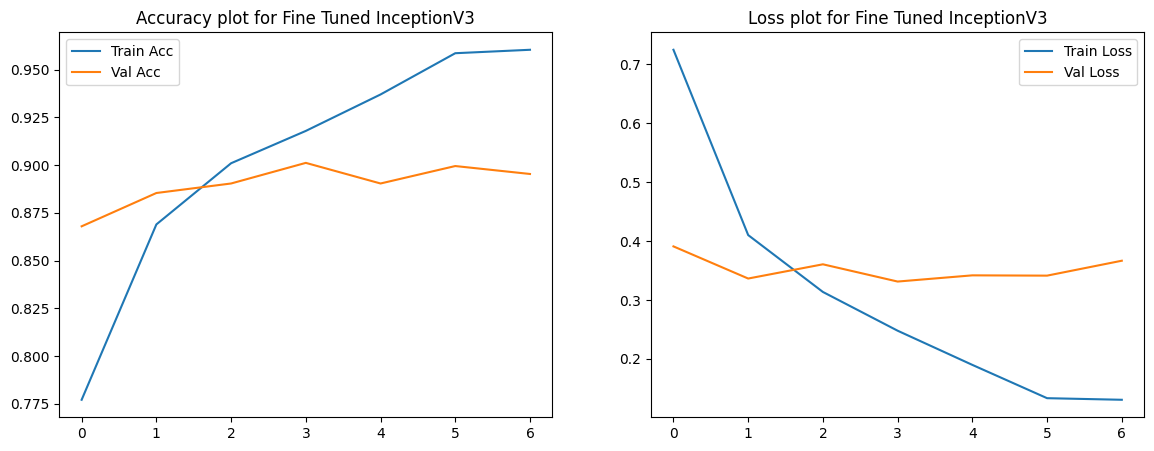

In [13]:
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(inception_finetuned_history.history['accuracy'], label='Train Acc')
    plt.plot(inception_finetuned_history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy plot for Fine Tuned InceptionV3")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(inception_finetuned_history.history['loss'], label='Train Loss')
    plt.plot(inception_finetuned_history.history['val_loss'], label='Val Loss')
    plt.title("Loss plot for Fine Tuned InceptionV3")
    plt.legend()
    plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 319ms/step


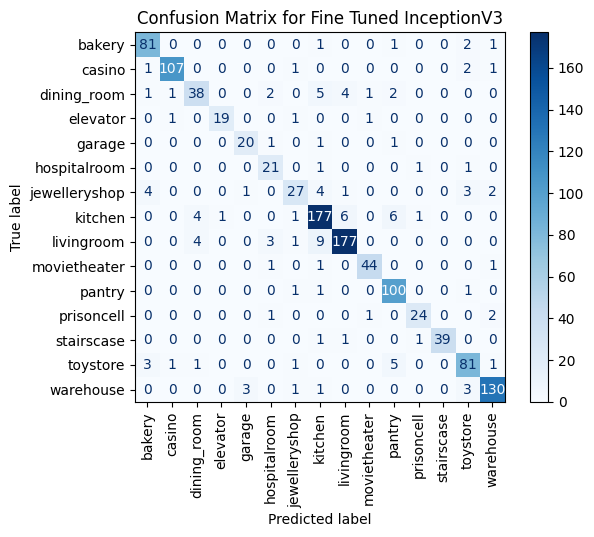

               precision    recall  f1-score   support

       bakery       0.90      0.94      0.92        86
       casino       0.97      0.96      0.96       112
  dining_room       0.81      0.70      0.75        54
     elevator       0.95      0.86      0.90        22
       garage       0.83      0.87      0.85        23
 hospitalroom       0.72      0.88      0.79        24
jewelleryshop       0.79      0.64      0.71        42
      kitchen       0.88      0.90      0.89       196
   livingroom       0.94      0.91      0.92       194
 movietheater       0.94      0.94      0.94        47
       pantry       0.87      0.97      0.92       103
   prisoncell       0.89      0.86      0.87        28
   stairscase       1.00      0.93      0.96        42
     toystore       0.87      0.87      0.87        93
    warehouse       0.94      0.94      0.94       138

     accuracy                           0.90      1204
    macro avg       0.89      0.88      0.88      1204
 weighte

In [14]:
# Generate predictions for the indoor scene validation set
indoor_val_loader.reset()
val_predictions = inception_final_model.predict(indoor_val_loader)
predicted_labels = np.argmax(val_predictions, axis=1)
true_labels = indoor_val_loader.classes
# Compute the confusion matrix for indoor scene classification
confusion_mat = confusion_matrix(true_labels, predicted_labels)
confusion_display = ConfusionMatrixDisplay(
    confusion_matrix=confusion_mat,
    display_labels=scene_class_labels)
confusion_display.plot(xticks_rotation='vertical',cmap='Blues')
plt.title("Confusion Matrix for Fine Tuned InceptionV3")
plt.show()
# Classification report showing precision, recall, and F1-scores
print(classification_report(true_labels, predicted_labels, target_names=scene_class_labels))

Found 766 images belonging to 15 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 309s 13s/step - accuracy: 0.8956 - loss: 0.3386
Inception Test Accuracy: 0.8759791254997253
Inception Test Loss: 0.4040333330631256
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 505ms/step


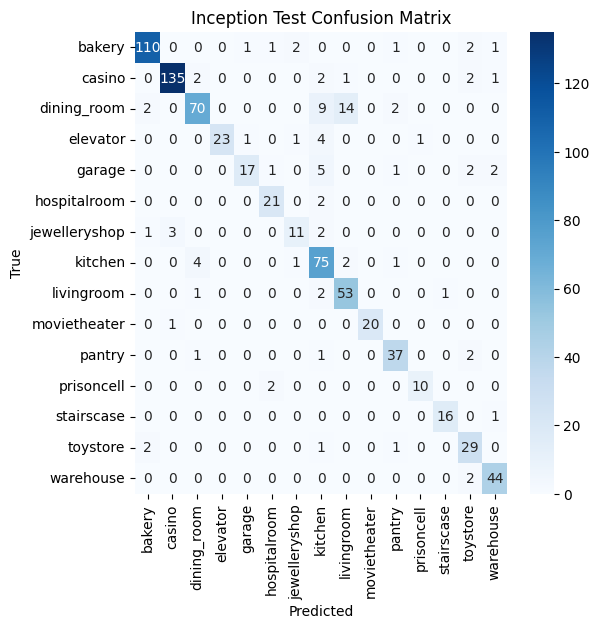

               precision    recall  f1-score   support

       bakery       0.96      0.93      0.94       118
       casino       0.97      0.94      0.96       143
  dining_room       0.90      0.72      0.80        97
     elevator       1.00      0.77      0.87        30
       garage       0.89      0.61      0.72        28
 hospitalroom       0.84      0.91      0.88        23
jewelleryshop       0.73      0.65      0.69        17
      kitchen       0.73      0.90      0.81        83
   livingroom       0.76      0.93      0.83        57
 movietheater       1.00      0.95      0.98        21
       pantry       0.86      0.90      0.88        41
   prisoncell       0.91      0.83      0.87        12
   stairscase       0.94      0.94      0.94        17
     toystore       0.74      0.88      0.81        33
    warehouse       0.90      0.96      0.93        46

     accuracy                           0.88       766
    macro avg       0.88      0.86      0.86       766
 weighte

In [17]:
# Create test generator using same preprocessing
indoor_test_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

indoor_test_dir = "/content/drive/MyDrive/Dataset/test"

indoor_test_loader = indoor_test_data_generator.flow_from_directory(
    indoor_test_dir,
    target_size=indoor_image_size,
    batch_size=indoor_batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the saved best performing Inception fine-tuned model
inception_test_model = keras.models.load_model(
    "best_inceptionv3_model.h5",
    compile=False
)

# Compile to enable metrics
inception_test_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Evaluate
test_loss, test_accuracy = inception_test_model.evaluate(
    indoor_test_loader,
    verbose=1
)

print("Inception Test Accuracy:", test_accuracy)
print("Inception Test Loss:", test_loss)

# Predict for confusion matrix and classification report
indoor_test_loader.reset()
test_predictions = inception_test_model.predict(indoor_test_loader)
pred_labels = np.argmax(test_predictions, axis=1)
true_labels = indoor_test_loader.classes
class_names = list(indoor_test_loader.class_indices.keys())

# Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Inception Test Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

# Print classification report
print(classification_report(true_labels, pred_labels, target_names=class_names))


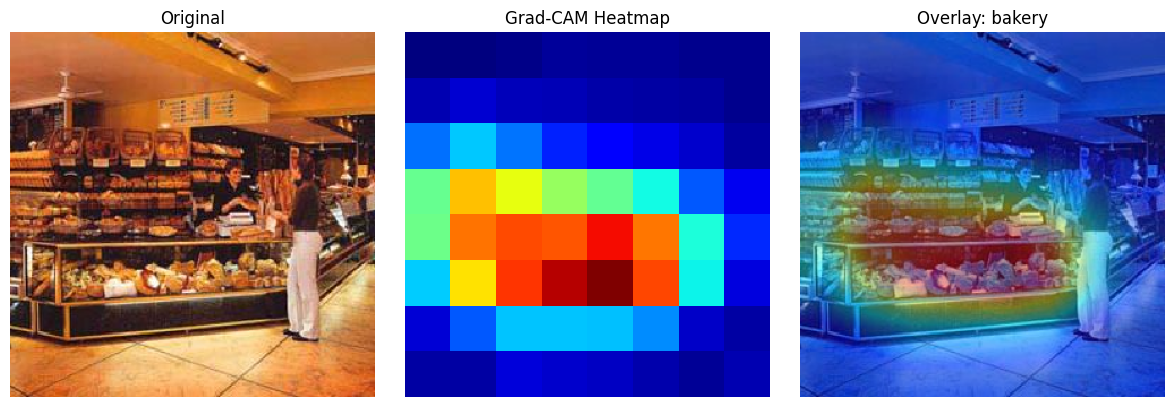

In [26]:
# GRAD-CAM FOR INCEPTIONV3 MODEL
def load_and_preprocess_inception(img_path):
    img = keras.preprocessing.image.load_img(img_path, target_size=indoor_image_size)
    arr = keras.preprocessing.image.img_to_array(img)
    arr_disp = arr / 255.0
    arr_model = preprocess_input(arr.copy())
    arr_model = np.expand_dims(arr_model, axis=0)
    return img, arr_disp, arr_model

def gradcam_inception(image_tensor, model, last_conv_layer_name="mixed10"):
    layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model([model.input], [layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_tensor)
        class_index = tf.argmax(predictions[0])
        class_score = predictions[:, class_index]

    grads = tape.gradient(class_score, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)

    return heatmap.numpy(), int(class_index.numpy())

def overlay_heatmap_on_image(image_display, heatmap):
    img_uint8 = (image_display * 255).astype("uint8")
    heatmap_resized = cv2.resize(heatmap, (img_uint8.shape[1], img_uint8.shape[0]))
    heat_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    composite = cv2.addWeighted(img_uint8, 0.6, heat_color, 0.4, 0)
    composite = cv2.cvtColor(composite, cv2.COLOR_BGR2RGB)
    return composite

# Choose image index from test set
img_index = 0
img_path = indoor_test_loader.filepaths[img_index]

original, display_img, model_img = load_and_preprocess_inception(img_path)
heatmap, pred_idx = gradcam_inception(model_img, inception_test_model)
pred_label = class_names[pred_idx]

overlay = overlay_heatmap_on_image(display_img, heatmap)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(original)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap="jet")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Overlay: {pred_label}")
plt.imshow(overlay)
plt.axis("off")

plt.tight_layout()
plt.show()

